<a href="https://colab.research.google.com/github/SanandhKumar02/MiniProject_ProstateCancer/blob/main/R_ProstateCancer_DESeq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
R.version.string

[1] "R version 4.2.0 (2022-04-22)"

In [ ]:
BiocManager::install("TCGAbiolinks")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Installing package(s) 'BiocVersion', 'TCGAbiolinks'

also installing the dependencies ‘plogr’, ‘png’, ‘Biostrings’, ‘bitops’, ‘RSQLite’, ‘KEGGREST’, ‘filelock’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘AnnotationDbi’, ‘BiocFileCache’, ‘BiocGenerics’, ‘GenomeInfoDb’, ‘XVector’, ‘Rcpp’, ‘R.oo’, ‘R.methodsS3’, ‘MatrixGenerics’, ‘Biobase’, ‘DelayedArray’, ‘downloader’, ‘biomaRt’, ‘GenomicRanges’, ‘XML’, ‘plyr’, ‘IRanges’, ‘S4Vectors’, ‘R.utils’, ‘SummarizedExperiment’, ‘TCGAbiolinksGUI.data’


Old packages: 'dbplyr', 'processx', 'tinytex', 'nlme'



In [ ]:
library(TCGAbiolinks)

In [ ]:
library(SummarizedExperiment)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [ ]:
library(ggplot2)

In [ ]:
BiocManager::install("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Installing package(s) 'DESeq2'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘xtable’, ‘futile.logger’, ‘snow’, ‘BH’, ‘annotate’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘RcppArmadillo’


Old packages: 'dbplyr', 'processx', 'tinytex', 'nlme'



In [ ]:
library(DESeq2)

# **Function to get Up-regulated and Down-regulated Genes**

In [ ]:
get_upregulated <- function(df){
    key <- intersect(rownames(df)[which(df$log2FoldChange>=1)],
              rownames(df)[which(df$pvalue<=0.05)])
    
    results <- as.data.frame((df)[which(rownames(df) %in% key),])
    return(results)
  }

In [ ]:
get_downregulated <- function(df){
  key <- intersect(rownames(df)[which(df$log2FoldChange<=-1)],
            rownames(df)[which(df$pvalue<=0.05)])
  
  results <- as.data.frame((df)[which(rownames(df) %in% key),])
  return(results)
}

# ***miRNA Differential Analysis***

## Downloading and Preparing Data

In [ ]:
mirna_query <- GDCquery(project = "TCGA-PRAD",
                        data.category = "Transcriptome Profiling",
                        data.type = "miRNA Expression Quantification",
                        experimental.strategy = "miRNA-Seq")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-PRAD

--------------------

oo Filtering results

--------------------

ooo By experimental.strategy

ooo By data.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



In [ ]:
GDCdownload(mirna_query, method = "api", files.per.chunk = 100,
            directory = "/content/Data")


GDCdownload will download 551 files. A total of 27.635813 MB




Downloading: 800 kB     

Downloading: 790 kB     

Downloading: 800 kB     

Downloading: 790 kB     

Downloading: 800 kB     

Downloading: 400 kB     

In [ ]:
miR_df <- GDCprepare(mirna_query, directory = "/content/Data")

  |======================================================================| 100%


In [ ]:
## remove columns we dont need, keep counts
rownames(miR_df) <- miR_df$miRNA_ID
miR_df <- miR_df[,-1]
number_cols <- ncol(miR_df)
subset <- seq(from = 1, to = number_cols, by = 3)
miR_df <- miR_df[, subset]

In [ ]:
## Strip read_count, just want the 'cases' ID
colnames(miR_df) <- gsub(".*_","",colnames(miR_df))
nrow(miR_df)
ncol(miR_df)
head(miR_df)

[1] 1881

[1] 551

,TCGA-EJ-7321-01A-31R-2262-13,TCGA-J4-A83M-01A-11R-A358-13,TCGA-EJ-5501-01A-01R-1579-13,TCGA-V1-A9OY-01A-11R-A41R-13,TCGA-EJ-5497-01A-02R-1579-13,TCGA-KK-A6E3-01A-21R-A30I-13,TCGA-HC-A6AS-01A-11R-A30I-13,TCGA-HC-8260-11A-01R-2262-13,TCGA-EJ-A8FO-11A-11R-A36B-13,TCGA-G9-6377-01A-11R-1964-13,⋯,TCGA-H9-A6BX-01A-31R-A310-13,TCGA-2A-A8VO-01A-11R-A37H-13,TCGA-G9-7519-01A-11R-2262-13,TCGA-HC-8260-01A-11R-2262-13,TCGA-HC-A6AP-01A-11R-A30I-13,TCGA-EJ-A8FO-01A-21R-A36B-13,TCGA-YL-A8SQ-01B-11R-A37H-13,TCGA-J4-A83J-11A-11R-A36B-13,TCGA-M7-A723-01A-12R-A32J-13,TCGA-G9-6370-01A-11R-1788-13
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,51384,37734,32491,43522,84251,23004,29078,25262,98606,85102,⋯,75660,22796,33406,31259,34031,47400,28772,62357,40116,22182
hsa-let-7a-2,51537,37846,32453,43443,84336,23173,29154,25285,100143,85016,⋯,75424,22665,33020,31219,33921,47397,28290,62452,39838,22410
hsa-let-7a-3,51277,37554,32658,43446,84391,23213,28906,25584,99437,84939,⋯,76109,22841,33212,31711,34118,47301,28696,62960,39901,22063
hsa-let-7b,35001,28807,31775,27308,86219,21941,23735,26412,98270,43293,⋯,53446,16914,36323,29629,32603,46076,20158,57235,40825,10417
hsa-let-7c,15057,18857,21198,23882,47062,36790,21241,23683,95837,41608,⋯,51912,19811,32768,22696,28238,28752,23028,62909,23682,22380
hsa-let-7d,1095,1511,602,1008,1654,866,883,805,1963,1412,⋯,2214,902,761,837,956,1216,610,2103,1287,643


In [ ]:
## Match to metadata
miR_meta <- mirna_query[[1]][[1]]

In [ ]:
miR_meta <- miR_meta[,c("cases", "sample_type")]
nrow(miR_meta)
ncol(miR_meta)

[1] 551

[1] 2

In [ ]:
miR_meta$sample_type <- as.character(miR_meta$sample_type)
table(miR_meta$sample_type)


         Metastatic       Primary Tumor Solid Tissue Normal 
                  1                 498                  52 

In [ ]:
metastatic_key <- miR_meta[which(miR_meta$sample_type == "Metastatic"),]
miR_meta <- miR_meta[!miR_meta[,2] == metastatic_key[,2],]
miR_df <- miR_df[, -grep(paste0(metastatic_key[,1]), colnames(miR_df))]

In [ ]:
head(miR_df)
nrow(miR_df)
ncol(miR_df)

,TCGA-EJ-7321-01A-31R-2262-13,TCGA-J4-A83M-01A-11R-A358-13,TCGA-EJ-5501-01A-01R-1579-13,TCGA-V1-A9OY-01A-11R-A41R-13,TCGA-EJ-5497-01A-02R-1579-13,TCGA-KK-A6E3-01A-21R-A30I-13,TCGA-HC-A6AS-01A-11R-A30I-13,TCGA-HC-8260-11A-01R-2262-13,TCGA-EJ-A8FO-11A-11R-A36B-13,TCGA-G9-6377-01A-11R-1964-13,⋯,TCGA-H9-A6BX-01A-31R-A310-13,TCGA-2A-A8VO-01A-11R-A37H-13,TCGA-G9-7519-01A-11R-2262-13,TCGA-HC-8260-01A-11R-2262-13,TCGA-HC-A6AP-01A-11R-A30I-13,TCGA-EJ-A8FO-01A-21R-A36B-13,TCGA-YL-A8SQ-01B-11R-A37H-13,TCGA-J4-A83J-11A-11R-A36B-13,TCGA-M7-A723-01A-12R-A32J-13,TCGA-G9-6370-01A-11R-1788-13
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-let-7a-1,51384,37734,32491,43522,84251,23004,29078,25262,98606,85102,⋯,75660,22796,33406,31259,34031,47400,28772,62357,40116,22182
hsa-let-7a-2,51537,37846,32453,43443,84336,23173,29154,25285,100143,85016,⋯,75424,22665,33020,31219,33921,47397,28290,62452,39838,22410
hsa-let-7a-3,51277,37554,32658,43446,84391,23213,28906,25584,99437,84939,⋯,76109,22841,33212,31711,34118,47301,28696,62960,39901,22063
hsa-let-7b,35001,28807,31775,27308,86219,21941,23735,26412,98270,43293,⋯,53446,16914,36323,29629,32603,46076,20158,57235,40825,10417
hsa-let-7c,15057,18857,21198,23882,47062,36790,21241,23683,95837,41608,⋯,51912,19811,32768,22696,28238,28752,23028,62909,23682,22380
hsa-let-7d,1095,1511,602,1008,1654,866,883,805,1963,1412,⋯,2214,902,761,837,956,1216,610,2103,1287,643


[1] 1881

[1] 550

In [ ]:
head(miR_meta)
nrow(miR_meta)
ncol(miR_meta)

,cases,sample_type
,<chr>,<chr>
1,TCGA-EJ-7321-01A-31R-2262-13,Primary Tumor
2,TCGA-J4-A83M-01A-11R-A358-13,Primary Tumor
3,TCGA-EJ-5501-01A-01R-1579-13,Primary Tumor
4,TCGA-V1-A9OY-01A-11R-A41R-13,Primary Tumor
5,TCGA-EJ-5497-01A-02R-1579-13,Primary Tumor
6,TCGA-KK-A6E3-01A-21R-A30I-13,Primary Tumor


[1] 550

[1] 2

In [ ]:
## Rename conditions
miR_meta$sample_type <- gsub("Primary solid Tumor", "Tumor", miR_meta$sample_type)
miR_meta$sample_type <- gsub("Solid Tissue Normal", "Normal", miR_meta$sample_type)
miR_meta$sample_type <- as.factor(miR_meta$sample_type)
levels(miR_meta$sample_type)
colnames(miR_meta) <- c("cases", "Condition")

[1] "Normal"        "Primary Tumor"

In [ ]:
write.table(miR_meta, "/content/miR_meta.txt", quote = F, sep = "\t")

In [ ]:
nrow(miR_df)
ncol(miR_df)
nrow(miR_meta)
ncol(miR_meta)

[1] 1881

[1] 550

[1] 550

[1] 2

In [ ]:
## tidy vars
rm(mirna_query)
rm(subset)
rm(number_cols)
rm(metastatic_key)

In [ ]:
miR_dds <- DESeqDataSetFromMatrix(miR_df, colData = miR_meta, design = ~ Condition)
miR_dds$Condition <- relevel(miR_dds$Condition, ref = "Normal")
miR_dds <- DESeq(miR_dds)
resultsNames(miR_dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning 

[1] "Intercept"                         "Condition_Primary.Tumor_vs_Normal"

In [ ]:
## DESeq2 results
miR_res <- results(miR_dds, alpha = 0.05, name = "Condition_Primary.Tumor_vs_Normal")
summary(miR_res)
miR_res_df <- as.data.frame(miR_res)


out of 1513 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 169, 11%
LFC < 0 (down)     : 201, 13%
outliers [1]       : 0, 0%
low counts [2]     : 724, 48%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
miR_upreg <- get_upregulated(miR_res)
miR_downreg <- get_downregulated(miR_res)

In [ ]:
miR_upreg$miRNA_id <- rownames(miR_upreg)
miR_downreg$miRNA_id <- rownames(miR_downreg)

In [ ]:
miR_counts <- counts(miR_dds, normalized = T)
write.table(miR_counts, "/content/miR_norm.counts.txt", quote = F, sep = "\t")

In [ ]:
write.table(miR_upreg, "/content/miR_upreg.txt", quote = F, sep = "\t")
write.table(miR_downreg, "/content/miR_downreg.txt", quote = F, sep = "\t")

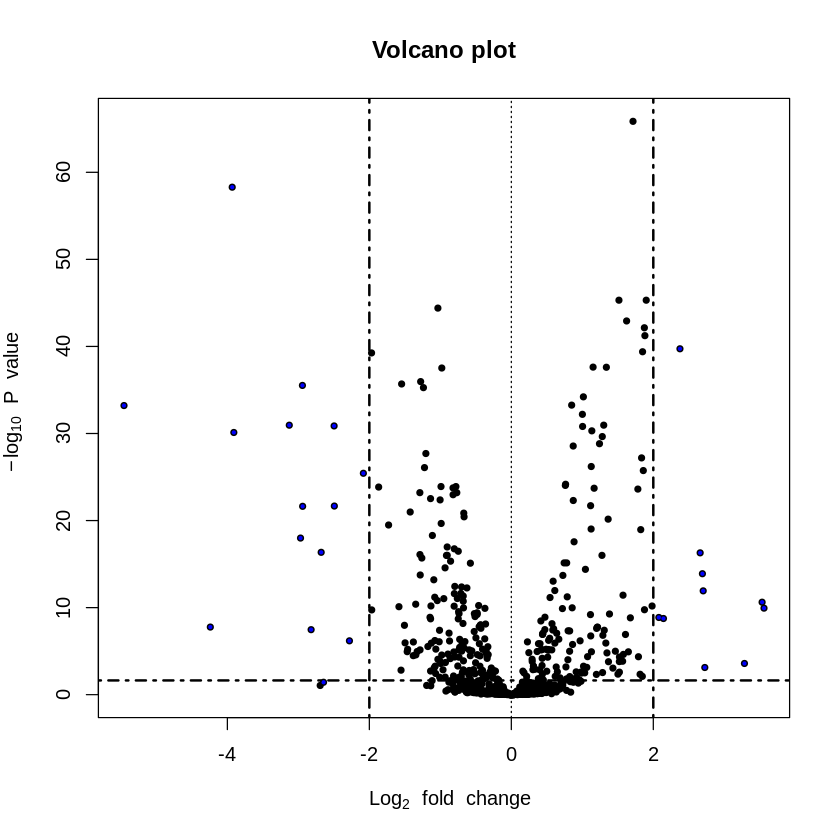

In [ ]:
with(miR_res_df, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~P~value)))

with(subset(miR_res_df, padj<0.05 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(padj), pch=20, col="blue", cex=0.5))

abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-2, col="black", lty=4, lwd=2.0)
abline(v=2, col="black", lty=4, lwd=2.0)
abline(h=-log10(max(miR_res_df$pvalue[miR_res_df$padj<0.05], na.rm=TRUE)), col="black", lty=4, lwd=2.0)

# RNA Differential Expression

In [ ]:
query <- GDCquery(project = "TCGA-PRAD", 
                  data.category = "Gene expression",
                  data.type = "Gene expression quantification",
                  experimental.strategy = "RNA-Seq",
                  platform = "Illumina HiSeq",
                  file.type = "results",
                  legacy = TRUE)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg19

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-PRAD

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By experimental.strategy

ooo By data.type

ooo By file.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



In [ ]:
GDCdownload(query, method = "api", files.per.chunk = 100,
            directory = "/content/Data")


GDCdownload will download 550 files. A total of 834.121914 MB




Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 30 MB     

In [ ]:
mrna_df <- GDCprepare(query, directory = "/content/Data")

--------------------

oo Reading 550 files

--------------------



|====================================================|100%                      Completed after 13 s 


--------------------

oo Merging 550 files

--------------------

Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

prad subtype information from:doi:10.1016/j.cell.2015.10.025



In [ ]:
mrna_meta <- mrna_df$sample

In [ ]:
mrna_meta <- cbind(mrna_meta, mrna_df$definition)

In [ ]:
mrna_df <- assay(mrna_df)

In [ ]:
delim_fn = function(x, n, i){
    do.call(c, lapply(x, function(X)
        paste(unlist(strsplit(X, "-"))[(n+1):(i)], collapse = "-")))
}

In [ ]:
colnames(mrna_df) <- delim_fn(x = colnames(mrna_df), n = 0, i = 4)

In [ ]:
mrna_meta <- as.data.frame(mrna_meta)
mrna_df <- as.data.frame(mrna_df)

In [ ]:
metastatic_key <- mrna_meta[which(mrna_meta[,2] == "Metastatic"),]
mrna_meta <- mrna_meta[!mrna_meta[,2] == metastatic_key[,2],]
mrna_df <- mrna_df[, -grep(paste0(metastatic_key[,1]), colnames(mrna_df))]

In [ ]:
mrna_meta[,2] <- as.character(mrna_meta[,2])

In [ ]:
mrna_meta[,2] <- gsub("Primary solid Tumor", "Tumor", mrna_meta[,2])
mrna_meta[,2] <- gsub("Solid Tissue Normal", "Normal", mrna_meta[,2])
mrna_meta[,2] <- as.factor(mrna_meta[,2])
levels(mrna_meta[,2])
colnames(mrna_meta) <- c("cases", "Condition")

[1] "Normal" "Tumor"

In [ ]:
write.table(mrna_df, "/content/Results/mrna_df.txt", quote = F, sep = "\t")

In [ ]:
write.table(mrna_meta, "/content/Results/mrna_meta.txt", quote = F, sep = "\t")

In [ ]:
mrna_dds <- DESeqDataSetFromMatrix(round(mrna_df), colData = mrna_meta, design = ~ Condition)

converting counts to integer mode



In [ ]:
mrna_dds$Condition <- relevel(mrna_dds$Condition, ref = "Normal")

In [ ]:
mrna_dds <- DESeq(mrna_dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1439 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
vsd <- varianceStabilizingTransformation(mrna_dds, blind=FALSE)

,TCGA-G9-7525-01A,TCGA-EJ-7789-01A,TCGA-EJ-7314-11A,TCGA-HC-8265-01A,TCGA-EJ-A46B-01A,TCGA-HC-7819-01A,TCGA-EJ-5510-01A,TCGA-HC-7080-01A,TCGA-CH-5769-11A,TCGA-KK-A7AY-01A,⋯,TCGA-G9-6377-01A,TCGA-V1-A8MF-01A,TCGA-G9-6499-11A,TCGA-J4-A67R-01A,TCGA-KK-A6E7-01A,TCGA-J9-A8CN-01A,TCGA-CH-5762-01A,TCGA-XJ-A9DX-01A,TCGA-KK-A6E5-01A,TCGA-EJ-5496-01A
A1BG|1,6.008894,7.355672,7.672604,7.907780,7.380921,6.189704,6.560988,5.889730,6.145200,6.520872,⋯,6.584258,6.959848,6.889952,7.406567,6.830122,6.074995,5.411722,8.238785,7.448119,5.840184
A2M|2,14.977996,14.768960,16.052200,14.783020,13.568532,13.518895,14.263595,14.022247,14.657321,14.457274,⋯,13.784273,14.996586,15.086310,14.495920,14.170037,14.425412,15.190929,13.686582,14.506364,13.316533
NAT1|9,7.369287,5.967220,8.657079,8.214435,9.172845,5.967724,8.689489,6.183797,8.645634,5.524921,⋯,8.042378,8.220037,9.312656,7.235903,9.267809,9.088459,7.819305,5.980150,9.675646,7.288150
NAT2|10,5.153428,4.052769,5.213812,4.687886,5.166692,4.522975,5.095599,5.115032,5.176564,4.514181,⋯,4.859166,5.722875,5.025388,5.173697,6.807294,4.465588,4.052769,4.052769,4.774214,4.706704
SERPINA3|12,16.425500,8.755545,14.887241,16.042970,10.837725,14.793632,15.035991,12.389362,15.395851,12.833889,⋯,15.029958,10.727668,14.168768,16.990727,10.022932,14.148247,13.947195,10.260316,12.506878,14.000804
AADAC|13,4.408430,4.052769,4.558712,4.052769,4.052769,4.052769,4.359825,4.052769,4.521184,4.052769,⋯,4.052769,4.052769,4.052769,4.591437,4.518895,4.052769,4.052769,4.052769,4.416300,4.052769


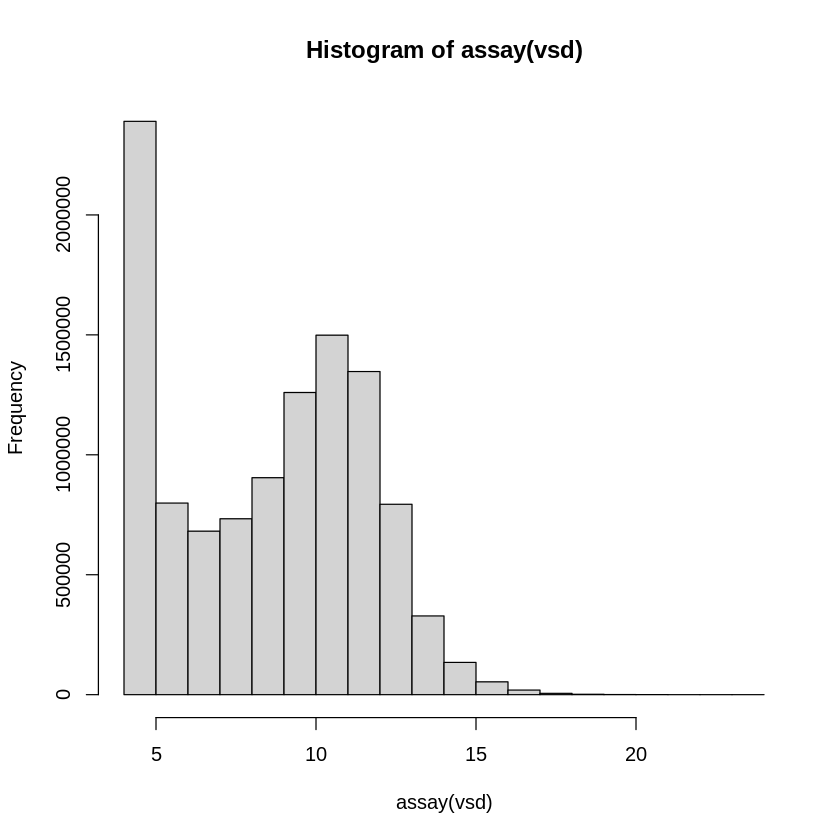

In [ ]:
head(assay(vsd))
hist(assay(vsd))

In [ ]:
resultsNames(mrna_dds)

[1] "Intercept"                 "Condition_Tumor_vs_Normal"

null device 
          1

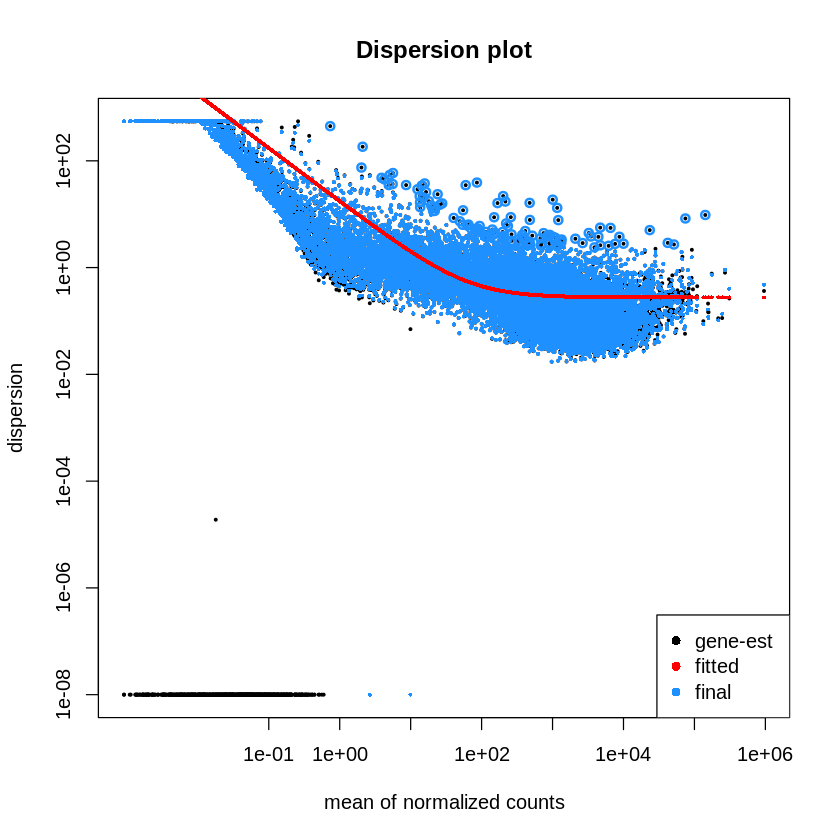

In [ ]:
# Plot Dispersions:
plotDispEsts(mrna_dds, main="Dispersion plot")
dev.off()

In [ ]:
mrna_res <- results(mrna_dds, name = "Condition_Tumor_vs_Normal")

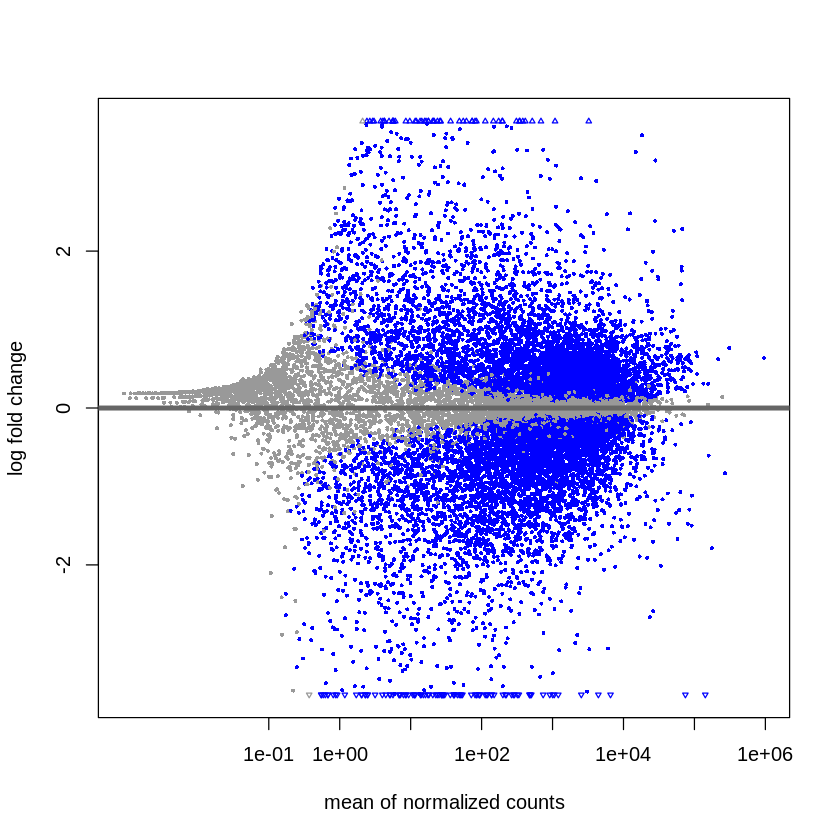

In [ ]:
plotMA(mrna_res)

In [ ]:
?results

In [ ]:
mrna_res_df <- as.data.frame(mrna_res)

In [ ]:
mrnaTable <- mrna_res_df

In [ ]:
mrnaTable$Gene_id <- rownames(mrnaTable)

In [ ]:
write.table(mrnaTable, "/content/Results/mrna_res_df.txt", quote = F, sep = "\t")

In [ ]:
summary(mrna_res)


out of 19669 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6878, 35%
LFC < 0 (down)     : 6338, 32%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
mrna_upreg <- get_upregulated(mrna_res)

In [ ]:
mrna_downreg <- get_downregulated(mrna_res)

In [ ]:
mrna_counts <- counts(mrna_dds, normalized = T)

In [ ]:
mrna_upreg$Gene_id <- rownames(mrna_upreg)

In [ ]:
mrna_downreg$Gene_id <- rownames(mrna_downreg)

In [ ]:
mrna_res_df$Gene_id <- rownames(mrna_res_df)

In [ ]:
write.table(mrna_counts, "/content/Results/mRNA_norm.counts.txt", quote = F, sep = "\t")

In [ ]:
write.table(mrna_res_df, "/content/Results/mrna_res_deseq2.txt", quote = F, sep = "\t")

In [ ]:
write.table(mrna_upreg, "/content/Results/mRNA_upreg.txt", quote = F, sep = "\t", row.names = F)
write.table(mrna_downreg, "/content/Results/mRNA_downreg.txt", quote = F, sep = "\t", row.names = F)

In [ ]:
write.csv(as.data.frame(mrna_upreg), file="mrna_upreg.csv")
write.csv(as.data.frame(mrna_downreg), file="mrna_downreg.csv")
write.csv(as.data.frame(mrna_counts), file="mrna_counts.csv")
write.csv(as.data.frame(mrna_res_df), file="mrna_res_df.csv")

In [ ]:
par(mar=c(5,5,5,5), cex=1.0, cex.main=1.4, cex.axis=1.4, cex.lab=1.4)

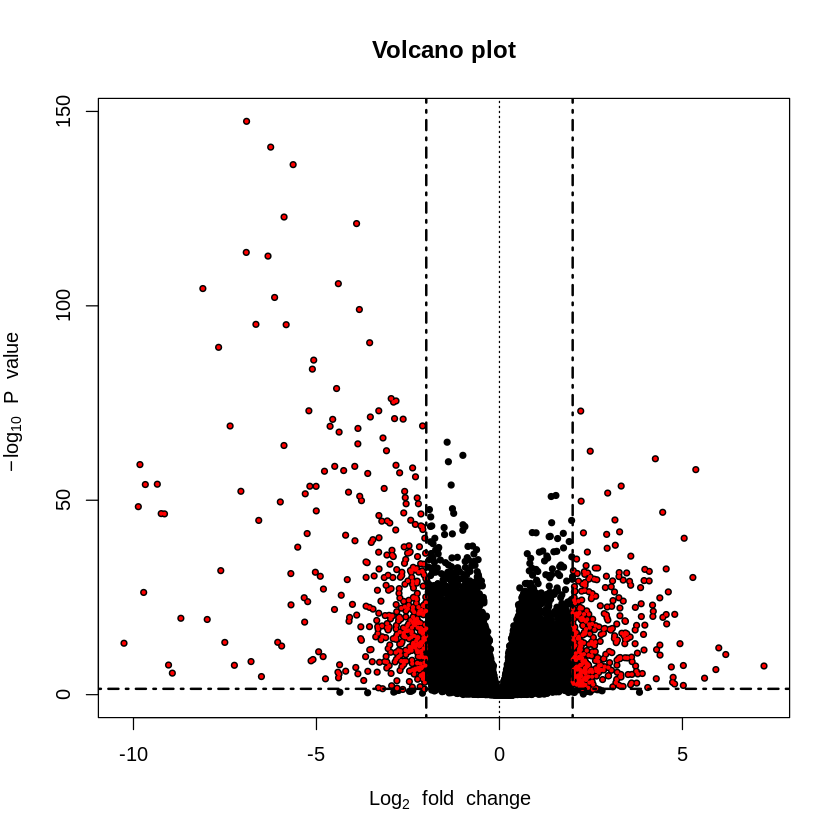

In [ ]:
with(mrna_res_df, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~P~value)))

with(subset(mrna_res_df, padj<0.05 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))

#with(subset(mrna_res_df, padj<0.05 & abs(log2FoldChange)>2), text(log2FoldChange, -log10(padj), labels=subset(rownames(mrna_res_df), mrna_res_df$padj<0.05 & abs(mrna_res_df$log2FoldChange)>2), cex=0.8, pos=3))

#Add lines for absolute FC>2 and P-value cut-off at FDR Q<0.05
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-2, col="black", lty=4, lwd=2.0)
abline(v=2, col="black", lty=4, lwd=2.0)
abline(h=-log10(max(mrna_res_df$pvalue[mrna_res_df$padj<0.05], na.rm=TRUE)), col="black", lty=4, lwd=2.0)

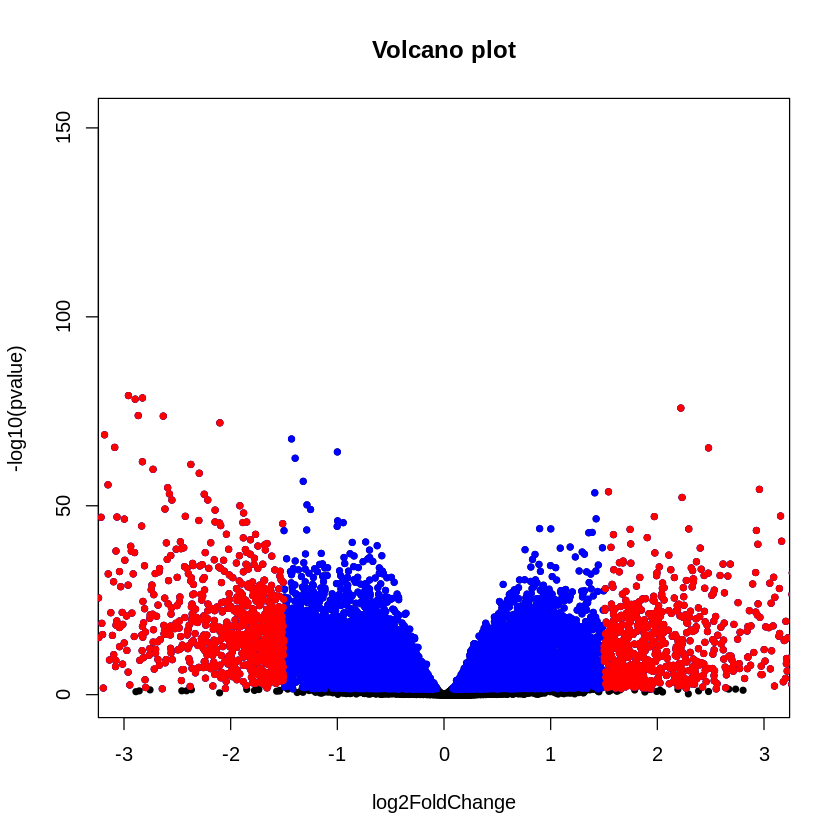

In [ ]:
with(mrna_res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))
with(subset(mrna_res, padj<0.05 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(mrna_res, padj<0.05 & abs(log2FoldChange)>1.5), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

In [ ]:
library(DESeq2)